In [2]:
using JuMP, Ipopt
using Plots

basicTerrain(x, y) = exp(-1(x^2 + y^2)) + exp(-0.5((x-2)^2 + y^2))

function potential(vec)
    return basicTerrain(vec[1], vec[2])
end

k = 4              
instances = zeros(Int,4)  
wps = zeros(2,k)    

instances[1] = 1
instances[2] = 30
instances[3] = 70
instances[4] = 100

# define waypoints
wps = [-2 -2;
        0  0;
        1  0;
       -2 -2]

function least_dangerous(λ, ξ) 

    m = Model(Ipopt.Optimizer)
    register(m, :basicTerrain, 2, basicTerrain, autodiff=true)
    register(m, :sum, 1, sum; autodiff = true)
    set_optimizer_attributes(m, "print_level" => 0 )
    @variable(m, position[1:instances[k], 1:2]) # Position
    @variable(m, velocity[1:instances[k], 1:2]) # Velocity
    @variable(m, thrust[1:instances[k], 1:2])   # Thrust

    # Dynamics (no initial velocity)
    @constraint(m, velocity[1,:] .== [0 0])

    @constraint(m, [-0.5 -0.5] .<= velocity .<= [0.5 0.5])
    @constraint(m, [-0.5 -0.5] .<= thrust .<= [0.5 0.5])
    


    for t in 1:instances[k]-1
        # Position is updated in thrust
        @constraint(m, position[t+1,:] .== position[t,:] + velocity[t,:])
        @NLconstraint(m, velocity[t+1,:1] == velocity[t,:1] + thrust[t,:1] + ξ * (basicTerrain(position[t,:]...) - basicTerrain(position[t+1,:]...)))
        @NLconstraint(m, velocity[t+1,:2] == velocity[t,:2] + thrust[t,:2] + ξ * (basicTerrain(position[t,:]...) - basicTerrain(position[t+1,:]...)))
        @NLconstraint(m, sum(abs(thrust[t,:1])) <= 100)
        @NLconstraint(m, sum(abs(thrust[t,:2])) <= 100)
    end

    # Reach all waypoints
    for i in [1 k]
        @constraint(m, position[instances[i],:] .== wps[i,:])
    end

    @objective(m, Min, sum(thrust.^2) + λ * sum( (position[instances[2:k],:]-wps[2:k,:]).^2  ) )
    optimize!(m)
    
    J1 = value.(sum(thrust.^2))
    J2 = value.(sum( (position[instances[2:k],:]-wps[2:k,:]).^2  ))
    velocity = value.(velocity)
    thrust = value.(thrust)
    path = value.(position)
    
    return (velocity,thrust,path)
end

least_dangerous (generic function with 1 method)

In [3]:
λ = 10
ξ = 1
(velocity,thrust,path) = least_dangerous(λ, ξ)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



([1.742291724440479e-21 -9.327185874275818e-21; 0.005938595514839981 0.045215833417440114; … ; -0.12155334548688466 -0.08744252975507928; -0.12109048128646951 -0.08697964577505563], [0.005938595514839981 0.045215833417440114; 0.008686152895886909 0.042408392978106564; … ; -8.941419710969467e-9 1.083818883447822e-8; 1.4879692133643397e-8 1.4879737159170658e-8], [-2.0 -2.0; -2.0 -2.0; … ; -1.8784466545131155 -1.9125574702449206; -2.0 -2.0])

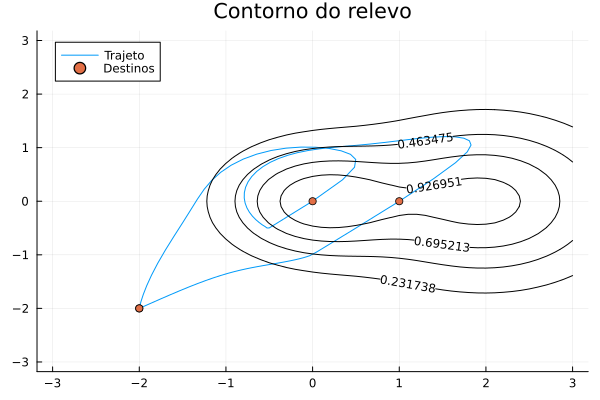

In [4]:
plot(path[:,1], path[:,2], label="Trajeto")
scatter!(wps[:,1], wps[:,2], label="Destinos")
contour!(-3:0.1:3, -3:0.1:3, basicTerrain, color=:black, clabels=true, levels=4, cbar=false, title="Contorno do relevo")

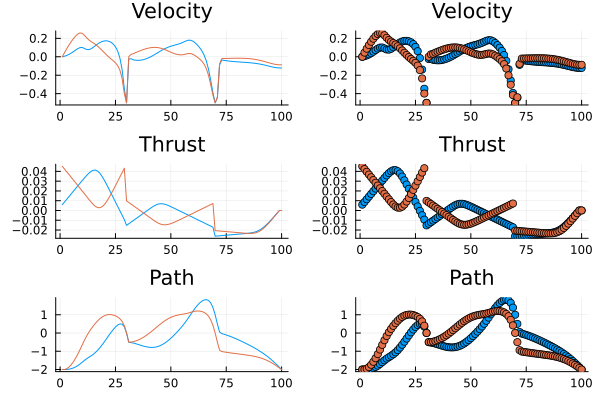

In [5]:
#velocity, impulse and route plot
p1 = plot(velocity, title="Velocity")
p2 = plot(velocity, seriestype=:scatter, label="data", title="Velocity")

p3 = plot(thrust, title="Thrust")
p4 = plot(thrust, seriestype=:scatter, label="data", title="Thrust")

p5 = plot(path, title="Path")
p6 = plot(path, seriestype=:scatter, label="data", title="Path")

plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), legend=false)



#plot!(sqrt.(thrust[1,:].^2 + thrust[2,:].^2))
#plot!(basicTerrain.(path...))


[0.008398442318534734, 0.012284075230209602, 0.016169604831075428, 0.02005489274809709, 0.02393974148190684, 0.02782387860586417, 0.03170638389231763, 0.03558497156948549, 0.039454032045319276, 0.043298877481277344, 0.04708133203935658, 0.05071046863173105, 0.05400221505427743, 0.05665112728121846, 0.05825201267584301, 0.058401838146593325, 0.05685808762675399, 0.05365740559073467, 0.04910287614008103, 0.04362519063275494, 0.037622499654486635, 0.0313714697335386, 0.02502404180479784, 0.018647906810409315, 0.012267294464423614, 0.005888962729505075, 0.00048568039032409195, 0.006856772226380999, 0.013225848467249522, 0.021586440720828323, 0.019287802079599993, 0.016989175464297405, 0.0146905672821377, 0.012391965028958726, 0.010093340614654863, 0.007794725677094291, 0.0054961030666096184, 0.003197479021028403, 0.000899188447615052, 0.0013931384428124403, 0.0036491517533017315, 0.005781070942298697, 0.007627719905424194, 0.008992315716232973, 0.009723388628506729, 0.009781441140420151, 0

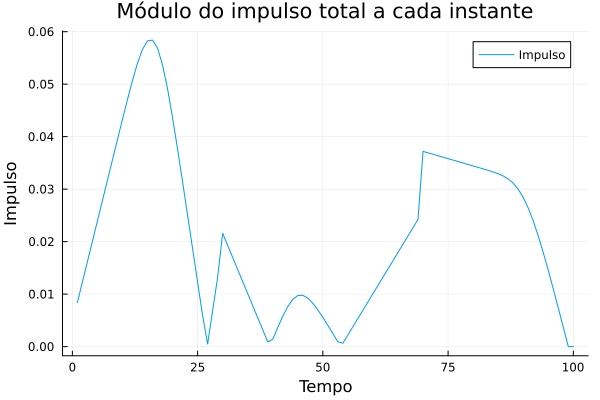

In [6]:
#Modulus of the total impulse at each instant
j = sqrt.(thrust[:,1].^2  + thrust[:,1].^2) 
println(j) #module value


plot(sqrt.(thrust[:,1].^2  + thrust[:,1].^2), label="Impulso", title="Módulo do impulso total a cada instante", xlabel="Tempo", ylabel="Impulso")